### Import Library and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

### Pre Exploratory Data Analysis

In [3]:
# Dataset Overview
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train_df.shape

(891, 12)

In [6]:
list(train_df)

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [7]:
train_df = train_df.rename(columns = {'PClass' : 'Passenger_class',
                           'SibSp'  : 'With_Sibling_Spouses',
                           'Parch'  : 'With_Parent_Children'})

list(train_df)

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'With_Sibling_Spouses',
 'With_Parent_Children',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [8]:
# check missing value
def missing_values_table(dataframe):
    nan_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_missing = dataframe[nan_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[nan_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    df_missing = pd.concat([n_missing, np.round(ratio, 2)], axis=1, keys=['n_missing', 'ratio'])
    print(df_missing, end='\n')

In [9]:
missing_values_table(train_df)

          n_missing  ratio
Cabin           687  77.10
Age             177  19.87
Embarked          2   0.22


In [10]:
train_df = train_df.drop('Cabin', axis=1)

In [11]:
def grab_col_names(dataframe, id_column='PassengerId', target_column='Survived', categorical_th=10, cardinality_th=30):
    # categorical cols
    categorical_columns = dataframe.select_dtypes(include=['object']).columns
    
    # numerical_but_cat dan cat_high_car
    numerical_but_cat = [col for col in dataframe.select_dtypes(include=['number']).columns 
                         if dataframe[col].nunique() < categorical_th]
    cat_high_car = [col for col in categorical_columns if dataframe[col].nunique() > cardinality_th]
    
    categorical_columns = [col for col in categorical_columns if col not in cat_high_car]
    categorical_columns += numerical_but_cat
        
    # numerical cols
    numerical_columns = dataframe.select_dtypes(include=['number']).columns
    numerical_columns = [col for col in numerical_columns if col not in numerical_but_cat]
    
    # remove target and id columns if present in numerical_columns
    numerical_columns = [col for col in numerical_columns if col not in [target_column, id_column]]
            
    print(f"Column Observed: {dataframe.shape[1]}")
    print(f"Row Observed: {dataframe.shape[0]}")
    print(f'cat_cols: {len(categorical_columns)}')
    print(f'num_cols: {len(numerical_columns)}')
    print(f'cat_high_car: {len(cat_high_car)}')
    print(f'numerical_but_cat: {len(numerical_but_cat)}')

    return categorical_columns, numerical_columns, cat_high_car, numerical_but_cat

cat_cols, num_cols, cat_high_car, numerical_but_cat = grab_col_names(train_df)

Column Observed: 11
Row Observed: 891
cat_cols: 6
num_cols: 2
cat_high_car: 2
numerical_but_cat: 4


In [12]:
print(cat_cols)

['Sex', 'Embarked', 'Survived', 'Pclass', 'With_Sibling_Spouses', 'With_Parent_Children']


In [13]:
print(num_cols)

['Age', 'Fare']


In [14]:
print(cat_high_car)

['Name', 'Ticket']


In [15]:
print(numerical_but_cat)

['Survived', 'Pclass', 'With_Sibling_Spouses', 'With_Parent_Children']


        Sex      Ratio
Sex                   
male    577  64.758698
female  314  35.241302


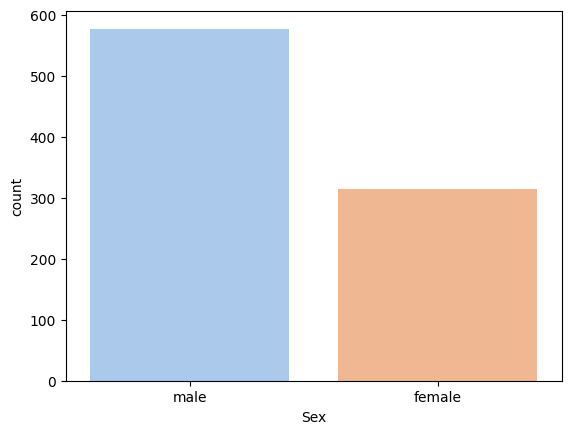

--------------------------------------------
          Embarked      Ratio
Embarked                     
S              644  72.278339
C              168  18.855219
Q               77   8.641975


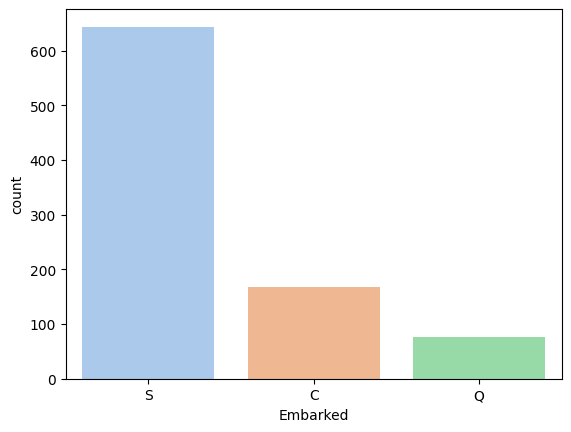

--------------------------------------------
          Survived      Ratio
Survived                     
0              549  61.616162
1              342  38.383838


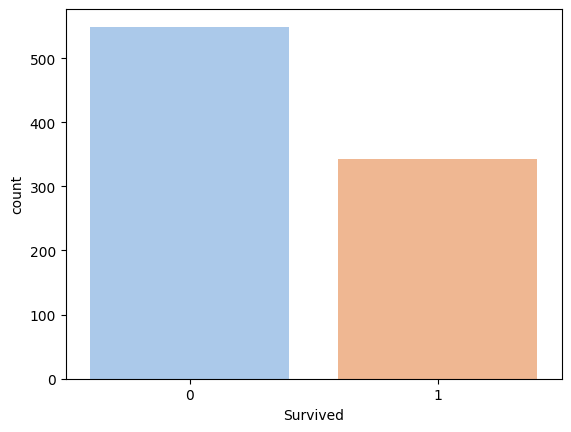

--------------------------------------------
        Pclass      Ratio
Pclass                   
3          491  55.106622
1          216  24.242424
2          184  20.650954


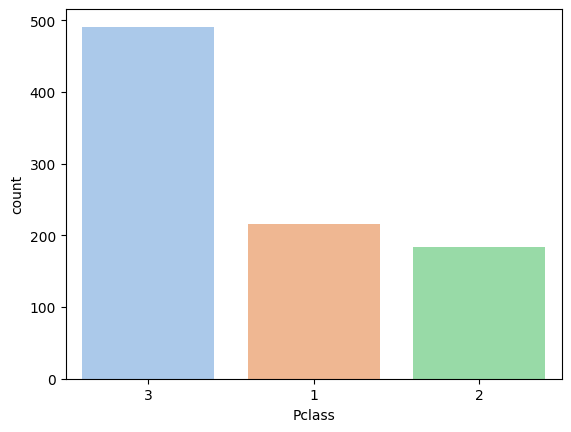

--------------------------------------------
                      With_Sibling_Spouses      Ratio
With_Sibling_Spouses                                 
0                                      608  68.237935
1                                      209  23.456790
2                                       28   3.142536
4                                       18   2.020202
3                                       16   1.795735
8                                        7   0.785634
5                                        5   0.561167


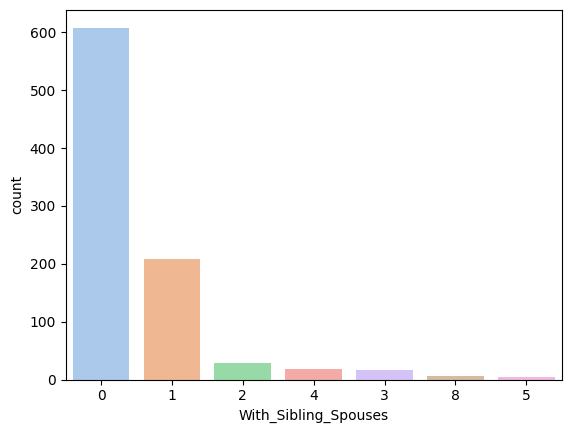

--------------------------------------------
                      With_Parent_Children      Ratio
With_Parent_Children                                 
0                                      678  76.094276
1                                      118  13.243547
2                                       80   8.978676
5                                        5   0.561167
3                                        5   0.561167
4                                        4   0.448934
6                                        1   0.112233


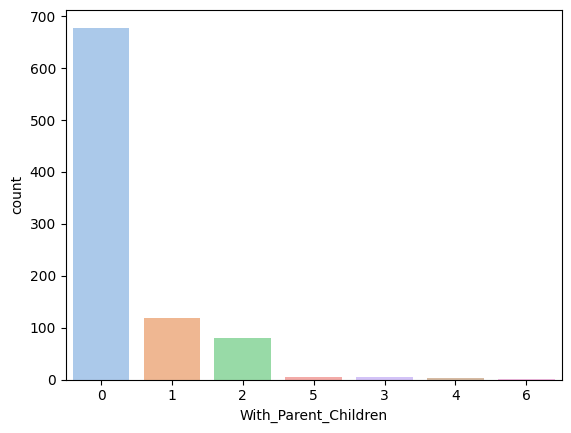

--------------------------------------------


In [16]:
# Categorical Columns Ratio
def cat_summary(dataframe, col_name, plot=False):
    if dataframe[col_name].dtypes == "bool":
        dataframe[col_name] = dataframe[col_name].astype(int)
        
        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100 * dataframe[col_name].value_counts()/len(dataframe)}))
        
        if plot:
            sns.countplot(x=dataframe[col_name], palette='pastel', data=dataframe, order=dataframe[col_name].value_counts().index)
            plt.show(block=True)
            
        print("--------------------------------------------")
        
        
    else:
        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100 * dataframe[col_name].value_counts()/len(dataframe)}))
        
        if plot:
            sns.countplot(x=dataframe[col_name], palette='pastel', data=dataframe, order=dataframe[col_name].value_counts().index)
            plt.show(block=True)
            
        print("--------------------------------------------")
        
for col in cat_cols:
    cat_summary(train_df, col, True)

In [17]:
# Survival Mean for Every Categorical Columns
def target_summary_with_cat(dataframe, target, cat_cols):
    dataframe[target] = pd.to_numeric(dataframe[target], errors='coerce')
    dataframe = dataframe.dropna(subset=[target])

    target_mean = dataframe.groupby(cat_cols)[target].mean().sort_values(ascending=False)
    print(pd.DataFrame({"Target MEAN": target_mean }), 
          end = "\n\n\n -------------- \n")

for col in cat_cols:
    target_summary_with_cat(train_df, "Survived", col)

        Target MEAN
Sex                
female     0.742038
male       0.188908


 -------------- 
          Target MEAN
Embarked             
C            0.553571
Q            0.389610
S            0.336957


 -------------- 
          Target MEAN
Survived             
1                 1.0
0                 0.0


 -------------- 
        Target MEAN
Pclass             
1          0.629630
2          0.472826
3          0.242363


 -------------- 
                      Target MEAN
With_Sibling_Spouses             
1                        0.535885
2                        0.464286
0                        0.345395
3                        0.250000
4                        0.166667
5                        0.000000
8                        0.000000


 -------------- 
                      Target MEAN
With_Parent_Children             
3                        0.600000
1                        0.550847
2                        0.500000
0                        0.343658
5                

In [18]:
print(num_cols)

['Age', 'Fare']


count    714.000000
mean      29.699118
std       14.526497
min        0.420000
5%         4.000000
10%       14.000000
20%       19.000000
30%       22.000000
40%       25.000000
50%       28.000000
60%       31.800000
70%       36.000000
80%       41.000000
90%       50.000000
95%       56.000000
99%       65.870000
max       80.000000
Name: Age, dtype: float64


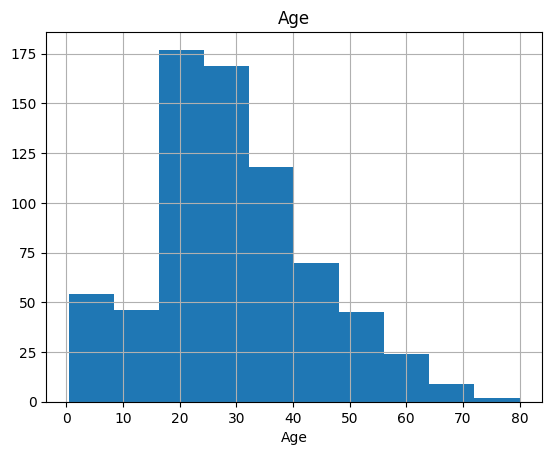

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
5%         7.225000
10%        7.550000
20%        7.854200
30%        8.050000
40%       10.500000
50%       14.454200
60%       21.679200
70%       27.000000
80%       39.687500
90%       77.958300
95%      112.079150
99%      249.006220
max      512.329200
Name: Fare, dtype: float64


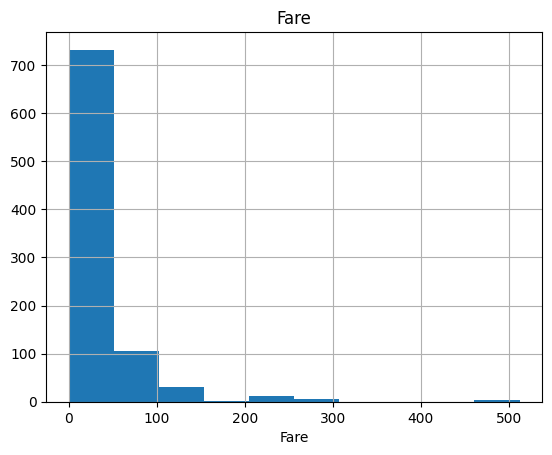

In [19]:
# Numerical Columns Ratio Analysis
def num_summarry(dataframe, numerical_col, plot=False):
    quantiles = [0.05,
                 0.10,
                 0.20,
                 0.30,
                 0.40,
                 0.50,
                 0.60,
                 0.70,
                 0.80,
                 0.90,
                 0.95,
                 0.99]
    
    print(dataframe[numerical_col].describe(quantiles))
    
    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in num_cols:
    num_summarry(train_df, col, plot=True)

In [20]:
# Survival Mean for Every Numerical Columns
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: 'mean'}),
                                        end = "\n -------------- \n")
    
for col in num_cols:
    target_summary_with_num(train_df, "Survived", col)

                Age
Survived           
0         30.626179
1         28.343690
 -------------- 
               Fare
Survived           
0         22.117887
1         48.395408
 -------------- 


### Data Preprocessing

In [21]:
# Filling missing value
def fill_missing_values(dataframe, numerical_columns, categorical_columns):
    df_filled = dataframe.copy()
    
    numericImputer = SimpleImputer(strategy='median')
    df_filled[numerical_columns] = numericImputer.fit_transform(df_filled[numerical_columns])
    
    categoricImputer = SimpleImputer(strategy='most_frequent')
    df_filled[categorical_columns] = categoricImputer.fit_transform(df_filled[categorical_columns])
    
    return df_filled

In [22]:
train_df = fill_missing_values(train_df, num_cols, cat_cols)

In [23]:
missing_values_table(train_df)

Empty DataFrame
Columns: [n_missing, ratio]
Index: []


In [24]:
# check duplicated value
train_df.duplicated().sum()

0

In [25]:
train_df.nunique()

PassengerId             891
Survived                  2
Pclass                    3
Name                    891
Sex                       2
Age                      88
With_Sibling_Spouses      7
With_Parent_Children      7
Ticket                  681
Fare                    248
Embarked                  3
dtype: int64

In [26]:
def unique_values(df):
    for column in df.columns:
        print(f"Unique values in '{column}':")
        print(df[column].unique())
        print('---------------')

In [27]:
unique_values(train_df)

Unique values in 'PassengerId':
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 23

In [28]:
unique_counts = train_df[cat_cols].nunique()

# One Hot Encoding if unique counts < 5 
cat_cols_OHE = [col for col in cat_cols if unique_counts[col] < 5]

# Label Encoding if unique counts >= 5
cat_cols_LE = [col for col in cat_cols if unique_counts[col] >= 5]

In [29]:
cat_cols_OHE

['Sex', 'Embarked', 'Survived', 'Pclass']

In [30]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [31]:
train_df = one_hot_encoder(train_df, cat_cols_OHE)

In [32]:
cat_cols_LE

['With_Sibling_Spouses', 'With_Parent_Children']

In [33]:
label_encoders = {}

for col in cat_cols_LE:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    label_encoders[col] = le

In [34]:
train_df

,PassengerId,Name,Age,With_Sibling_Spouses,With_Parent_Children,Ticket,Fare,Sex_male,Embarked_Q,Embarked_S,Survived_1,Pclass_2,Pclass_3
0,1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,True,False,True,False,False,True
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,False,False,False,True,False,False
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,False,False,True,True,False,True
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,False,False,True,True,False,False
4,5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,True,False,True,False,True,False
887,888,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,False,False,True,True,False,False
888,889,"Johnston, Miss. Catherine Helen ""Carrie""",28.0,1,2,W./C. 6607,23.4500,False,False,True,False,False,True
889,890,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,True,False,False,True,False,False


### Post Exploratory Data Analysis

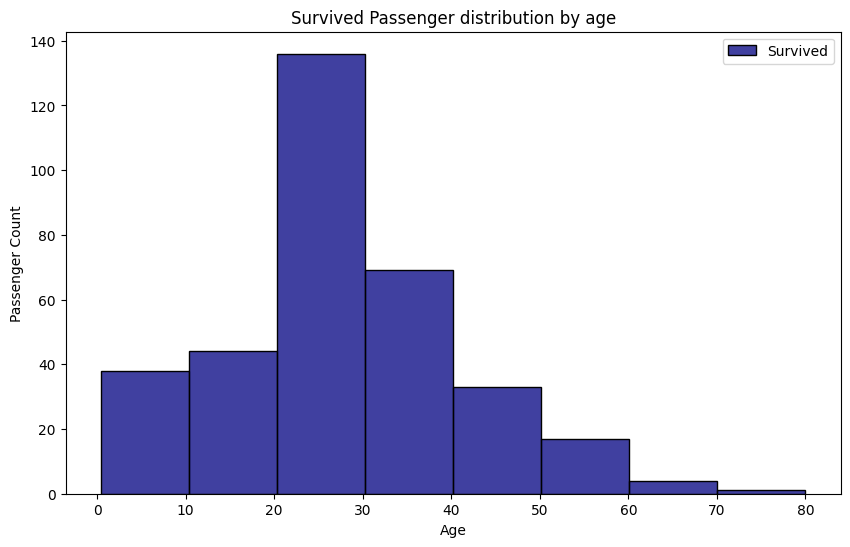

In [35]:
# 1. Survived passenger distribution by age 
plt.figure(figsize=(10,6))
sns.histplot(train_df[train_df['Survived_1'] == True]['Age'], color='navy', label='Survived', bins=8)
plt.title('Survived Passenger distribution by age')
plt.xlabel('Age')
plt.ylabel('Passenger Count')
plt.legend()

plt.show()

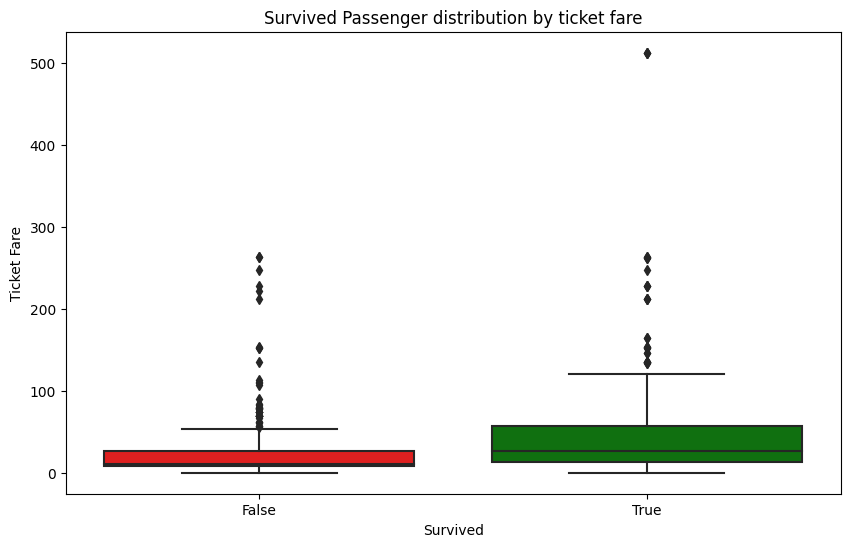

In [36]:
# 2. Surived passenger distribution by ticket fare
plt.figure(figsize=(10,6))
sns.boxplot(x='Survived_1', y='Fare', data=train_df, palette={True: 'green',
                                                              False: 'red'})

plt.title('Survived Passenger distribution by ticket fare')
plt.xlabel('Survived')
plt.ylabel('Ticket Fare')

plt.show()

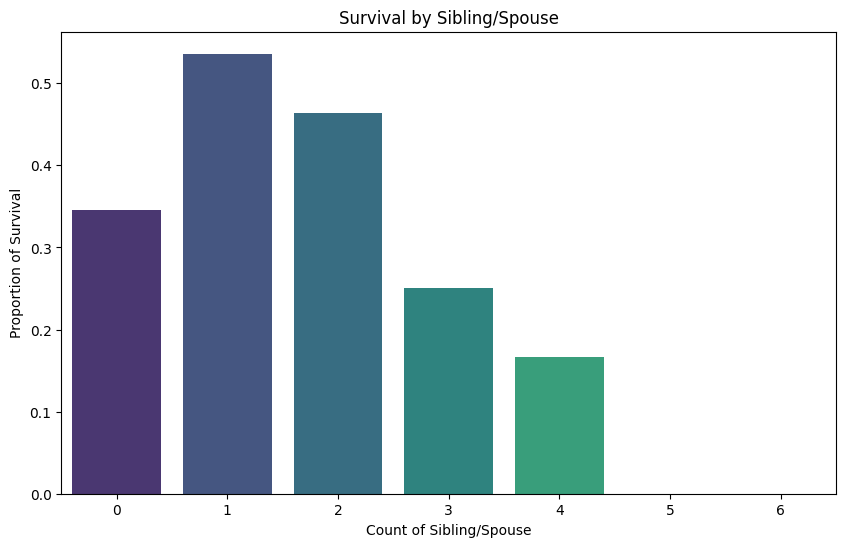

In [37]:
# 3. Survival by Sibling/Spouse
plt.figure(figsize=(10, 6))
sns.barplot(x='With_Sibling_Spouses', y='Survived_1', data=train_df, palette='viridis', errorbar=None)
plt.title('Survival by Sibling/Spouse')
plt.xlabel('Count of Sibling/Spouse')
plt.ylabel('Proportion of Survival')
plt.show()

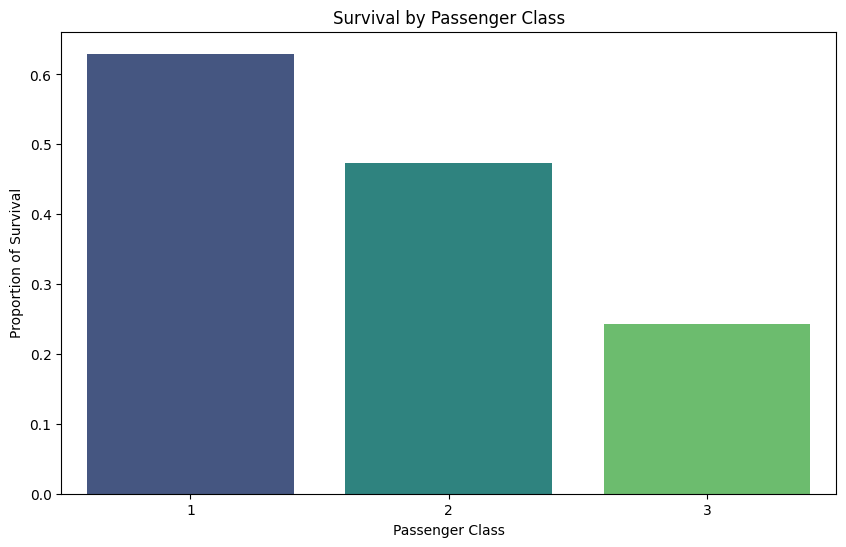

In [38]:
# 4. Survival by Passenger Class
train_df['Pclass'] = train_df[['Pclass_2', 'Pclass_3']].apply(lambda x: 2 
                                                              if x['Pclass_2'] 
                                                              else (3 if x['Pclass_3'] else 1), 
                                                              axis=1)

plt.figure(figsize=(10, 6))
sns.barplot(x='Pclass', y='Survived_1', data=train_df, palette='viridis', errorbar=None)
plt.title('Survival by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Proportion of Survival')
plt.show()

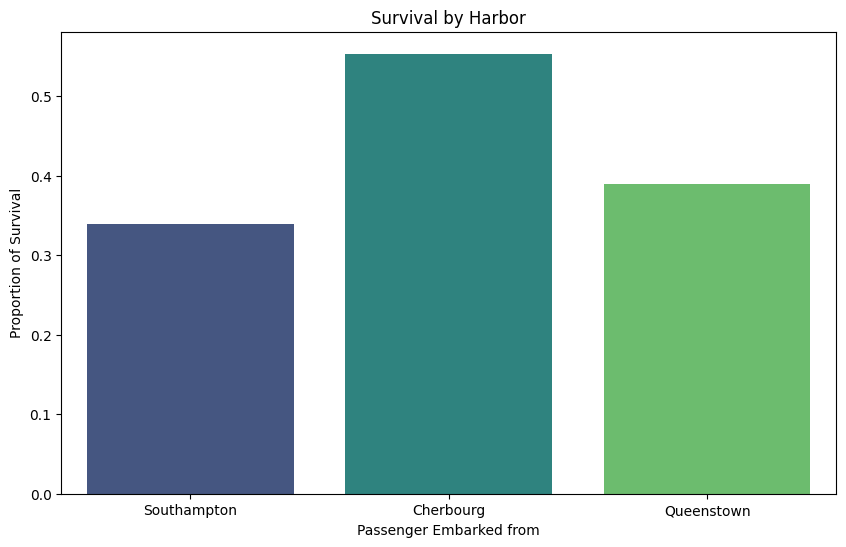

In [39]:
# 5. Survival by Harbor (Embarked)
train_df['Embarked'] = train_df[['Embarked_Q', 'Embarked_S']].apply(lambda x: 'Queenstown' 
                                                              if x['Embarked_Q'] 
                                                              else ('Southampton' if x['Embarked_S'] else 'Cherbourg'), 
                                                              axis=1)

plt.figure(figsize=(10, 6))
sns.barplot(x='Embarked', y='Survived_1', data=train_df, palette='viridis', errorbar=None)
plt.title('Survival by Harbor')
plt.xlabel('Passenger Embarked from')
plt.ylabel('Proportion of Survival')
plt.show()

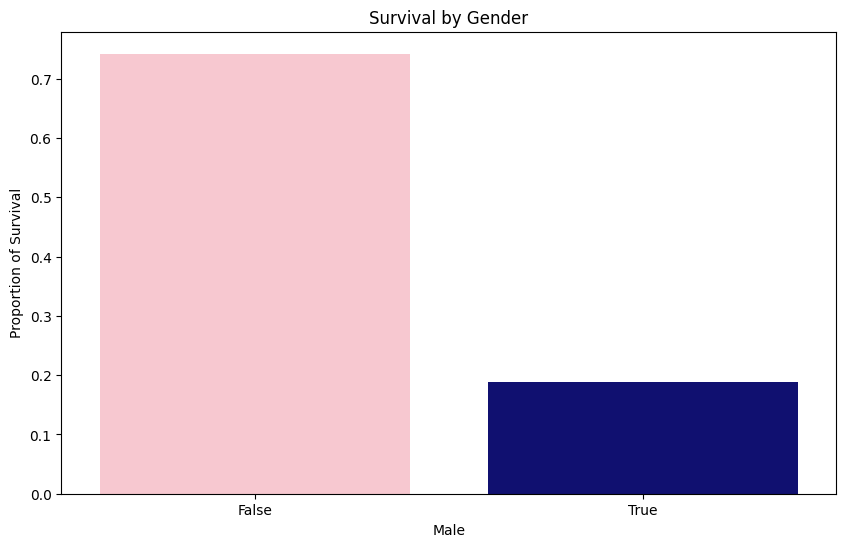

In [40]:
# 6. Survival comparison for Male and Female
plt.figure(figsize=(10, 6))
sns.barplot(x='Sex_male', y='Survived_1', data=train_df, palette={True: "navy", False: "pink"}, errorbar=None)
plt.title('Survival by Gender')
plt.xlabel('Male')
plt.ylabel('Proportion of Survival')
plt.show()

### Feature Selection

In [41]:
features = ['Pclass_2', 
            'Pclass_3', 
            'Sex_male', 
            'Age', 
            'With_Sibling_Spouses', 
            'With_Parent_Children', 
            'Fare', 
            'Embarked_Q', 
            'Embarked_S']

X = train_df[features]
y = train_df['Survived_1']

In [42]:
X

,Pclass_2,Pclass_3,Sex_male,Age,With_Sibling_Spouses,With_Parent_Children,Fare,Embarked_Q,Embarked_S
0,False,True,True,22.0,1,0,7.2500,False,True
1,False,False,False,38.0,1,0,71.2833,False,False
2,False,True,False,26.0,0,0,7.9250,False,True
3,False,False,False,35.0,1,0,53.1000,False,True
4,False,True,True,35.0,0,0,8.0500,False,True
...,...,...,...,...,...,...,...,...,...
886,True,False,True,27.0,0,0,13.0000,False,True
887,False,False,False,19.0,0,0,30.0000,False,True
888,False,True,False,28.0,1,2,23.4500,False,True
889,False,False,True,26.0,0,0,30.0000,False,False


In [43]:
y

0      False
1       True
2       True
3       True
4      False
       ...  
886    False
887     True
888    False
889     True
890    False
Name: Survived_1, Length: 891, dtype: bool

In [44]:
# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [45]:
# Data Train

In [46]:
X_train

,Pclass_2,Pclass_3,Sex_male,Age,With_Sibling_Spouses,With_Parent_Children,Fare,Embarked_Q,Embarked_S
199,True,False,False,24.0,0,0,13.0000,False,True
703,False,True,True,25.0,0,0,7.7417,True,False
823,False,True,False,27.0,0,1,12.4750,False,True
236,True,False,True,44.0,1,0,26.0000,False,True
679,False,False,True,36.0,0,1,512.3292,False,False
...,...,...,...,...,...,...,...,...,...
140,False,True,False,28.0,0,2,15.2458,False,False
500,False,True,True,17.0,0,0,8.6625,False,True
813,False,True,False,6.0,4,2,31.2750,False,True
421,False,True,True,21.0,0,0,7.7333,True,False


In [47]:
y_train

199    False
703    False
823     True
236    False
679     True
       ...  
140    False
500    False
813    False
421    False
805    False
Name: Survived_1, Length: 712, dtype: bool

In [48]:
# Data Test

In [49]:
X_test

,Pclass_2,Pclass_3,Sex_male,Age,With_Sibling_Spouses,With_Parent_Children,Fare,Embarked_Q,Embarked_S
417,True,False,False,18.0,0,2,13.000,False,True
307,False,False,False,17.0,1,0,108.900,False,False
87,False,True,True,28.0,0,0,8.050,False,True
577,False,False,False,39.0,1,0,55.900,False,True
684,True,False,True,60.0,1,1,39.000,False,True
...,...,...,...,...,...,...,...,...,...
368,False,True,False,28.0,0,0,7.750,True,False
851,False,True,True,74.0,0,0,7.775,False,True
501,False,True,False,21.0,0,0,7.750,True,False
520,False,False,False,30.0,0,0,93.500,False,True


In [50]:
y_test

417     True
307     True
87     False
577     True
684    False
       ...  
368     True
851    False
501    False
520     True
40     False
Name: Survived_1, Length: 179, dtype: bool

### Modelling

In [51]:
# Random Forest with 100 decision trees (we can tune it later) 
model = RandomForestClassifier(n_estimators=100, random_state=30)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=30)

In [52]:
# Predict Data Test
y_pred = model.predict(X_test)

In [53]:
comparison_df = pd.DataFrame({
    'Actual' : y_test,
    'Predicted' : y_pred
})

comparison_df

,Actual,Predicted
417,True,True
307,True,True
87,False,False
577,True,True
684,False,False
...,...,...
368,True,True
851,False,False
501,False,True
520,True,True


In [54]:
# Confusion Matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_matrix)

Confusion Matrix:
[[95 13]
 [23 48]]


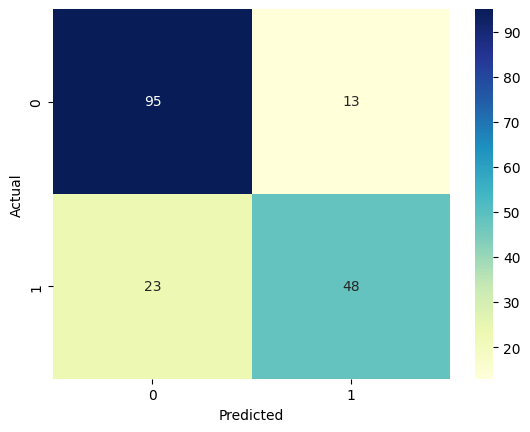

In [55]:
# Confusion Matrix Heatmap
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [56]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.80


In [57]:
# Comparison with other model
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [58]:
# Support Vector Machine
svm = SVC(random_state=30)
svm.fit(X_train, y_train)

SVC(random_state=30)

In [59]:
# XGBoost
xgb = XGBClassifier(random_state=30)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=30, ...)

In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [61]:
y_pred_rf = model.predict(X_test)
y_pred_svm = svm.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

In [62]:
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    print("Model Evaluation Metrics:")
    print("--------------------------")
    print(f"Accuracy       : {accuracy:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"F1-Score       : {f1:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    return accuracy, precision, recall, f1, conf_matrix

In [63]:
results_rf = evaluate_model(y_test, y_pred_rf)

Model Evaluation Metrics:
--------------------------
Accuracy       : 0.7989
Precision      : 0.7869
Recall         : 0.6761
F1-Score       : 0.7273

Confusion Matrix:
[[95 13]
 [23 48]]


In [64]:
results_svm = evaluate_model(y_test, y_pred_svm)

Model Evaluation Metrics:
--------------------------
Accuracy       : 0.6648
Precision      : 0.6897
Recall         : 0.2817
F1-Score       : 0.4000

Confusion Matrix:
[[99  9]
 [51 20]]


In [65]:
results_xgb = evaluate_model(y_test, y_pred_xgb)

Model Evaluation Metrics:
--------------------------
Accuracy       : 0.7933
Precision      : 0.7742
Recall         : 0.6761
F1-Score       : 0.7218

Confusion Matrix:
[[94 14]
 [23 48]]
